# Extracting Forest Areas from Google Maps Aerial Images: *Partial Report*

This partial report documents first explorations in achieving the project objective of extracting forest area from Google Maps aerial images. 

I begin by examining three sample images from my dataset. The following three images are selected because they have are very different in the features of interest. They will provide a good basis for testing segmentation and classification approaches. 
- Image 1 is mostly covered by trees. It provides a good base sample for different shades of forest green. I will use this image to set up my approach, while the other two images will help challenge the segmentation and classification algorithms. 
- Image 2 has smaller sections of forest cover among a diverse landscape of green and brown agricultural fields and roads. The forest areas in this image are diverse in green color, shape, and size. For example, there is a thin forest region following the shape of a river crossing the top left region of the image, a dark, dense region of forest in between some agricultural fields in the middle of the image, and another forest region at the top right that thins out and ‘bleeds’ into surrounding fields. This will test different aspects of my segmentation and classification methods.
- Image 3 has very few forest areas, but it shows a large body of water in the top left corner (Tietê River). It will be difficult to distinguish this river from the forest areas, because it has virtually the same color. 

The three images are displayed below:

Text(0.5, 1.0, 'Image 3')

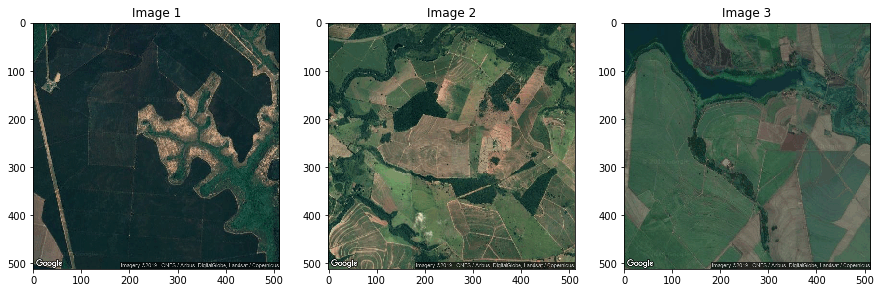

In [69]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib
from scipy.fftpack import fftn, ifftn

# read sample images in rgb
img = imageio.imread('images/lat-21.553191851763607_long -47.58674520014182_map.png')
img2 = imageio.imread('images/lat-22.284617723129536_long -48.18559920332148_map.png')
img3 = imageio.imread('images/lat-22.200495034324955_long -48.69176482972345_map.png')

# plot images
plt.figure(figsize=(15,10))
plt.subplot(131); plt.imshow(img); plt.title("Image 1")
plt.subplot(132); plt.imshow(img2); plt.title("Image 2")
plt.subplot(133); plt.imshow(img3); plt.title("Image 3")


Differentiating between rivers and forest areas is an example of a challenge that may arise in this classification task. The two plots below show 50x50 pixel subsets of images 1 and 3 respectively. The left shows a tree-covered area, while the right shows the river. For the viewer, the two plots have nearly the same color. Identifying forest areas will depend on texture, not just color.

Text(0.5, 1.0, 'River')

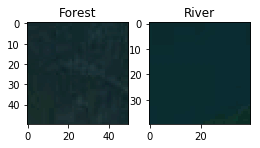

In [81]:
plt.figure(figsize=(4,2))
plt.subplot(121); plt.imshow(img[160:210,60:110]); plt.title('Forest')
plt.subplot(122); plt.imshow(img3[10:50,10:50]); plt.title('River')

As a preprocessing step, I remove the bottom pixel rows containing the google logo, because these black and white pixels are much darker/brighter than the rest of the image. Removing them expands the available range for the different color channels and makes it easier to segment the different regions.

In [49]:
# preprocessing step: crop google logo region
img = img[0:490,:]
img2 = img2[0:490,:]
img3 = img3[0:490,:]

Color will be a key identifying feature of forest areas, so I begin by examining the different color channels using both the RGB and the HSV color scheme. For example, below are the color channels and corresponding histograms for Image 1:

Text(0.5, 1.0, 'Value')

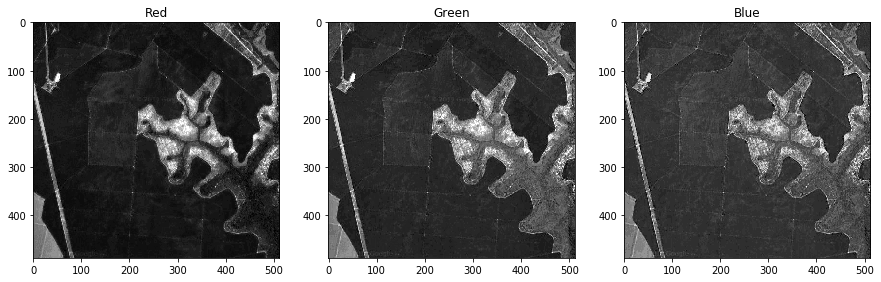

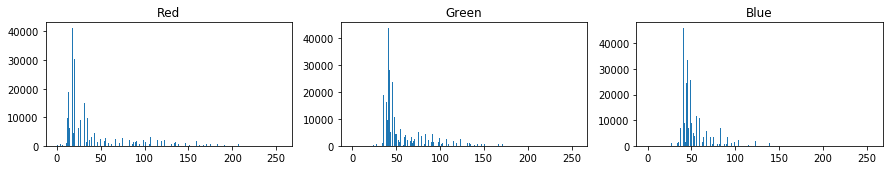

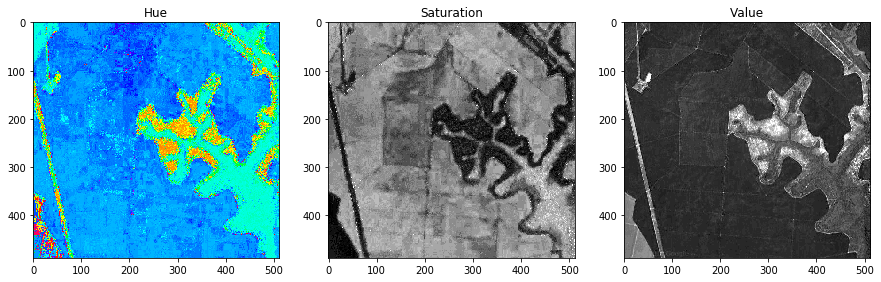

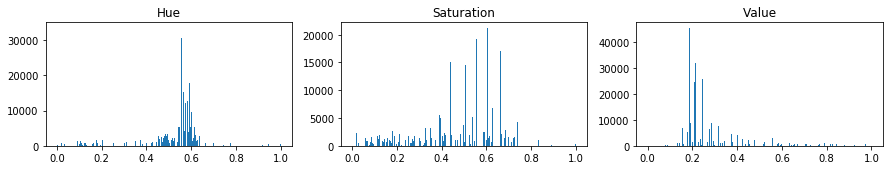

In [50]:
# for image 1:
# separate the RGB channels
Red = img[:,:,0].astype('float')
Green = img[:,:,1].astype('float')
Blue = img[:,:,2].astype('float')
# normalize to range 0-1
Rnorm = (Red - Red.min())/(Red.max() - Red.min())
Gnorm = (Green - Green.min())/(Green.max() - Green.min())
Bnorm = (Blue - Blue.min())/(Blue.max() - Blue.min())

# plot each R, G, B seperately
plt.figure(figsize=(15,10))
plt.subplot(231); plt.imshow(Red, cmap="gray"); plt.title("Red")
plt.subplot(232); plt.imshow(Green, cmap="gray"); plt.title("Green")
plt.subplot(233); plt.imshow(Blue, cmap="gray"); plt.title("Blue")
## Histograms
plt.figure(figsize=(15,5))
plt.subplot(234); plt.hist(Red.ravel(), bins=256, range=(0,255)); plt.title('Red')
plt.subplot(235); plt.hist(Green.ravel(), bins=256, range=(0,255)); plt.title('Green')
plt.subplot(236); plt.hist(Blue.ravel(), bins=256, range=(0,255)); plt.title('Blue')


# convert to hsv
img_hsv = matplotlib.colors.rgb_to_hsv(np.dstack((Rnorm, Gnorm, Bnorm)))

plt.figure(figsize=(15,10))
plt.subplot(231); plt.imshow(img_hsv[:,:,0], cmap="hsv"); plt.title("Hue");
plt.subplot(232); plt.imshow(img_hsv[:,:,1], cmap="gray"); plt.title("Saturation")
plt.subplot(233); plt.imshow(img_hsv[:,:,2], cmap="gray"); plt.title("Value")
## Histograms
plt.figure(figsize=(15,5))
plt.subplot(234); plt.hist(img_hsv[:,:,0].ravel(), bins=256, range=(0,1)); plt.title('Hue')
plt.subplot(235); plt.hist(img_hsv[:,:,1].ravel(), bins=256, range=(0,1)); plt.title('Saturation')
plt.subplot(236); plt.hist(img_hsv[:,:,2].ravel(), bins=256, range=(0,1)); plt.title('Value')

## Threshold segmentation using color
Most of the pixels in this image represent forest cover. This means that spikes in the color channels can help identify ranges of both R,G,B and H,S,V that correspond to the different green tones: those of forest areas and those of other vegetation, such as fields. 
As a simple baseline, an examination of the histograms gives the following ranges:
* RGB (range from 0-255): 
    * Red: 0 - 45 
    * Green: 30 - 55 
    * Blue: 30 - 50
    
* HSV (range from 0-1):
    * Hue: 0.4-0.6
    * Saturation: all levels
    * Value: 0 - 0.30

I use these ranges to define a simple threshold segmentation based on color. Below are the results for both color systems.

### 1. RGB

Text(0.5, 1.0, 'RGB Segmentation')

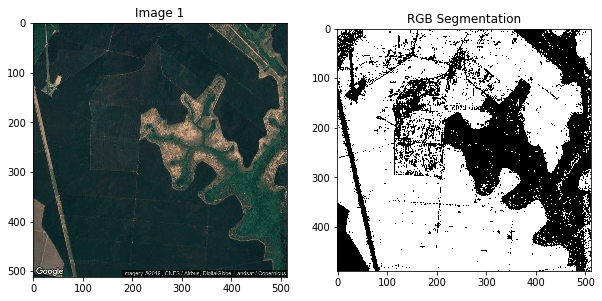

In [96]:
## RGB thresholding (histograms above)
# R<45, 30<G<55, 30<B<50
img_rgb_trees = np.where((Red<45) &
                         (Green>30) & (Green<55)
                         & (Blue>30) & (Blue<50),
                         1,0)
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img); plt.title('Image 1')
plt.subplot(122);plt.imshow(img_rgb_trees, cmap='gray'); plt.title('RGB Segmentation')


White areas represent forest cover. This segmentation correctly identifies most non-forest areas though there are some spurious false negative results (white dots). Similarly, most tree-covered areas are correctly classified, though some lighter forest regions are misclassified and/or very noisy.

### 2. HSV

Text(0.5, 1.0, 'HSV Segmentation')

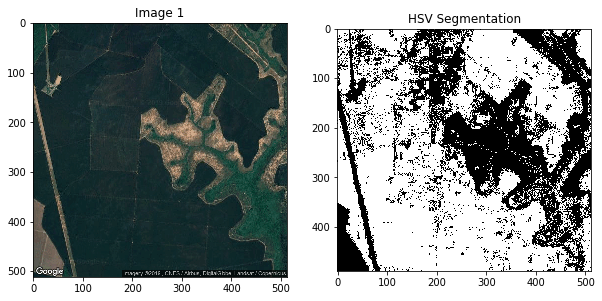

In [97]:
## HSV thresholding (histograms above)
img_hsv_trees = np.where((img_hsv[:,:,0]<0.6) & (img_hsv[:,:,0]>0.4) & 
                         (img_hsv[:,:,2]<0.3), 
                         1,0)
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img); plt.title('Image 1')
plt.subplot(122);plt.imshow(img_hsv_trees, cmap='gray'); plt.title('HSV Segmentation')

As with RGB, most forest and non-forest regions are identified correctly, though there is more misclassification of the lighter forest areas in the top center of the image. Further tuning of the thresholds can improve performance, but at the risk of overfitting. How do the threshold segmentations perform on the other two images?

### 3. RGB and HSV Segmentation on Test Images

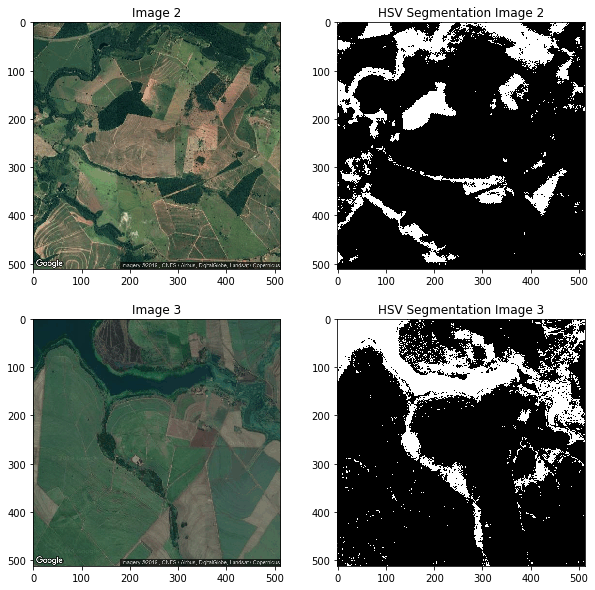

In [98]:
### HSV segmentation
def HSV_seg(img):
    # separate the channels
    Red = img[:,:,0].astype('float')
    Green = img[:,:,1].astype('float')
    Blue = img[:,:,2].astype('float')
    # normalized to range 0-1
    Rnorm = (Red - Red.min())/(Red.max() - Red.min())
    Gnorm = (Green - Green.min())/(Green.max() - Green.min())
    Bnorm = (Blue - Blue.min())/(Blue.max() - Blue.min())

    img_hsv = matplotlib.colors.rgb_to_hsv(np.dstack((Rnorm, Gnorm, Bnorm)))
    # apply threshold:
    img_hsv_trees = np.where((img_hsv[:,:,0]<0.6) & (img_hsv[:,:,0]>0.4) & 
                         (img_hsv[:,:,2]<0.3), 
                         1,0)
    return(img_hsv_trees)

## apply to images 2 and 3:
img2_hsv_trees = HSV_seg(img2)
img3_hsv_trees = HSV_seg(img3)

# plot results:
plt.figure(figsize=(10,10))
plt.subplot(221); plt.imshow(img2); plt.title("Image 2");
plt.subplot(222); plt.imshow(img2_hsv_trees, cmap = 'gray'); plt.title("HSV Segmentation Image 2");
plt.subplot(223); plt.imshow(img3); plt.title("Image 3");
plt.subplot(224); plt.imshow(img3_hsv_trees, cmap = 'gray'); plt.title("HSV Segmentation Image 3");

## Vegetation Indices
Following the example in (Torres-Sanchez et al, 2014), I compute different vegetation indices to help classify forest areas.
* Color Index of Vegetation (CIVE)
$$CIVE = 0.441r - 0.881g + 0.385b + 18.78745$$

* Woebbecke Index
$$WI = \frac{g-b}{r-g}$$
* Excess Green (ExG)
$$ExG = 2g-r-b$$
* Excess Green minus Excess Red (ExGR)
$$ExGR = ExG-1.4r-g$$

These four indices are based on chromatic coordinates - linear combinations of the RGB color channels defined as follows:
$$r = \frac{R}{R+G+B}$$

$$g = \frac{G}{R+G+B}$$

$$b = \frac{R}{R+G+B}$$

The vegetation indices for image 1 and their intensity histograms are plotted below.

Text(0.5, 1.0, 'Hist ExGR')

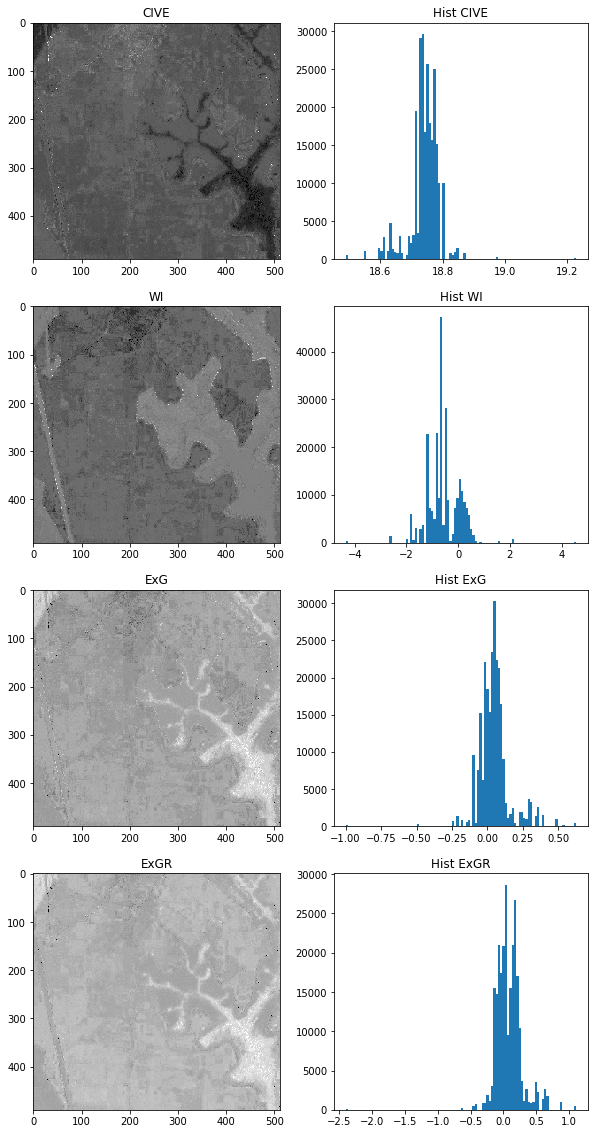

In [54]:
## Chromatic coordinates
r =  Rnorm / (Rnorm + Gnorm + Bnorm)
g = Gnorm / (Rnorm + Gnorm + Bnorm)
b = Bnorm / (Rnorm + Gnorm + Bnorm)


### CIVE (Color Index of Vegetation)
# CIVE =  0.441r - 0.881g + 0.385b + 18.78745
img_cive = 0.441*r - 0.881*g + 0.385*b + 18.78745
      
### ExG (Excess Green)
# ExG = 2g - r - b
img_exg = 2*g - r - b  

### ExG - ExR (Excess Green minus Excess Red)
# ExGR - ExG - 1.4r - g
img_exgr = img_exg - (1.4*r - g)

### Woebbecke index
# WI = (g - b) / |r - g|
# note: values -0.1<x<0.1 are set to 0.1
denom = abs(r - g)
denom = np.where(denom<0.1, 0.1, denom)
img_wi = (g - b) / denom


# plot the indices and their intensity histograms
plt.figure(figsize=(10,20))
# cive
plt.subplot(421); plt.imshow(img_cive, cmap = 'gray'); plt.title("CIVE");
plt.subplot(422); plt.hist(img_cive.ravel(), bins = 100); plt.title('Hist CIVE')
# wi
plt.subplot(423); plt.imshow(img_wi, cmap = 'gray'); plt.title("WI");
plt.subplot(424); plt.hist(img_wi.ravel(), bins = 100); plt.title('Hist WI')
# ExG
plt.subplot(425); plt.imshow(img_exg, cmap = 'gray'); plt.title("ExG");
plt.subplot(426); plt.hist(img_exg.ravel(), bins = 100); plt.title('Hist ExG')
# ExGR
plt.subplot(427); plt.imshow(img_exgr, cmap = 'gray'); plt.title("ExGR");
plt.subplot(428); plt.hist(img_exgr.ravel(), bins = 100); plt.title('Hist ExGR')

For image 1, the histogram of the Woebbecke index above clearly shows two separate distributions corresponding to the forest and non-forest areas.
The CIVE and ExG indices group forest areas together with some grass areas. This means the indices alone cannot be used for segmentation (at least in this sample image), but they can still provide useful information if combined with other features of the image.

As with color channels above, I use the histograms to set thresholds for segmentation:
* WI: 0 - (-0.1)
* CIVE: 18.71 - 18.81
* ExG: -0.12 - 0.24
* ExGR: -0.1 - 0.1

This yields for example the following segmentation of image 1 using the Woebbecke Index:

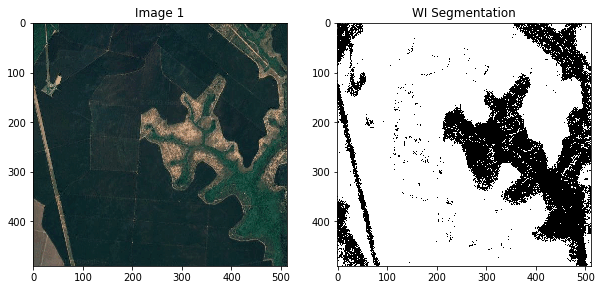

In [60]:
## vegetation indices
# WI: trees<0.1
img_wi_trees1 = np.where((img_wi<-0.1),
                        1,0)
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img); plt.title("Image 1");
plt.subplot(122); plt.imshow(img_wi_trees1, cmap='gray'); plt.title("WI Segmentation");

It appears to work fairly well for image 1. Can an optimization of the threshold improve segmentation results? I implement a simple algorithm from section 10.3.2 of (Gonzalez & Woods, 2006) to try and find a better threshold. The results are shown below: 

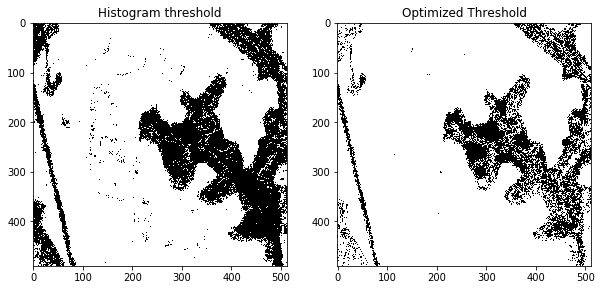

In [68]:
## Can we improve the threshold?
def threshold_finder(T0, img_in, delta_T):
    T_diff = delta_T+1
    while T_diff > delta_T:
        i1 = np.where(img_in<T0,
                      1,np.nan)*img_in
        i2 = np.where(img_in>T0,
                      1,np.nan)*img_in
        m1 = np.nanmean(i1)
        m2 = np.nanmean(i2)
        T = (1/2) * (m1 + m2)
        T_diff = abs(T0-T)
        T0=T
    return T0    

# find the threshold:    
T = threshold_finder(0.1, img_wi, 0.0001)    
# segment:
img_wi_trees2 = np.where((img_wi<0.1),
                        1,0)
# compare results:
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img_wi_trees1, cmap = 'gray'); plt.title("Histogram threshold");
plt.subplot(122); plt.imshow(img_wi_trees2, cmap = 'gray'); plt.title("Optimized Threshold");

Based on the result, there are advantages to each of the thresholds. Segmenting with the threshold found from the histogram has fewer false positives, i.e. non-forest pixels incorrectly classified as forest pixels. Yet as a tradeoff, the segmentation missed several tree-covered pixels. Conversely, the optimized threshold effectively classifies nearly all forest areas but at the expense of adding many false positive pixels. Combining the optimized threshold WI segmentation with other features could help remedy the situation, as could post-segmentation filtering of spurious regions.

In [71]:
# define function for other images
# computes color coordinates and returns Woebbecke index:
def WI(img):
    # separate the channels
    Red = img[:,:,0].astype('float')
    Green = img[:,:,1].astype('float')
    Blue = img[:,:,2].astype('float')
    # normalized to range 0-1
    Rnorm = (Red - Red.min())/(Red.max() - Red.min())
    Gnorm = (Green - Green.min())/(Green.max() - Green.min())
    Bnorm = (Blue - Blue.min())/(Blue.max() - Blue.min())
    ## Chromatic coordinates
    r =  Rnorm / (Rnorm + Gnorm + Bnorm)
    g = Gnorm / (Rnorm + Gnorm + Bnorm)
    b = Bnorm / (Rnorm + Gnorm + Bnorm)
    
    ### Woebbecke index
    # WI = (g - b) / |r - g|
    # note: values -0.1<x<0.1 are set to 0.1
    denom = abs(r - g)
    denom = np.where(denom<0.1, 0.1, denom)
    img_wi = (g - b) / denom
    
    return img_wi

## Next Steps
* Try more advanced segmentation techniques, e.g.:
    * clustering (using multiple color and vegetation features)
    * combinations of vegetation indices
* Filtering during pre-processing and/or after segmentation (remove spurious regions) - can it remove some of the noise that appears in the final result?
* Overlaying segmentation outlines over satellite images
* Extracting information on image texture to aid classification
* Interpretation of resulting images, e.g.:
    * compute pixel share of segmented areas to estimate forest cover of total land area
    * add geo-coded economic data, such as industry locations

